In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# check GPU availability
import torch
print("available devices count:", torch.cuda.device_count())
# disable CuDNN globally
torch.backends.cudnn.enabled = False

available devices count: 4


In [3]:
import torchvision
import numpy as np
normalize = lambda x: (x - torch.min(x)) / (torch.max(x) - torch.min(x)) * 2 - 1
transform = lambda x: normalize(torch.from_numpy(np.asarray(x, dtype=np.float32)))
mnist_train_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=True, download=True, transform=transform)
mnist_test_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=False, download=True, transform=transform)

In [4]:
torch.cuda.set_device(0)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, 
                                                     batch_size=100, 
                                                     shuffle=True, 
                                                     drop_last=True, 
                                                     num_workers=16)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_data, 
                                                     batch_size=256, 
                                                     shuffle=False, 
                                                     drop_last=False, 
                                                     num_workers=16)

In [5]:
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), -1))
        out = out.view(out.size(0), -1)
        return out
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [6]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [7]:
def train_discriminatortrain(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [8]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [9]:
from snippets.scaffold import TrainLoop, TestLoop
with TrainLoop(max_epochs=200, use_cuda=True, disp_epoch_freq=5).with_context() as loop:
    for _ in loop.iter_epochs():
        for step, (x, y) in loop.iter_steps(mnist_train_dataloader):
            real_x = x
            real_y = torch.ones(x.size()[0], 1).cuda()
            d_optimizer.zero_grad()
            if step % 2 == 0:
                real_loss = criterion(discriminator(real_x), real_y)
                d_loss = real_loss
            else:
                noise = torch.randn(x.size()[0], 100).cuda()
                fake_x = generator(noise)
                fake_y = torch.zeros(fake_x.size()[0], 1).cuda()
                fake_loss = criterion(discriminator(fake_x), fake_y)
                d_loss = fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            g_optimizer.zero_grad()
            noise = torch.randn(x.size(0), 100).cuda()
            fake_x = generator(noise)
            outputs = discriminator(fake_x)
            g_loss = criterion(discriminator(fake_x), real_y)
            g_loss.backward()
            g_optimizer.step()
            loop.submit_metric("d_loss", d_loss.detach().cpu().numpy())
            loop.submit_metric("g_loss", g_loss.detach().cpu().numpy())
        

[epoch:5/200 step:3000 ETA:1404.231s] d_loss: 0.519902(±0.284146) g_loss: 1.447530(±0.696244) step_time(s): 0.009646(±0.005722) epoch_time(s): 7.201183(±0.265916)
[epoch:10/200 step:6000 ETA:1356.599s] d_loss: 0.409133(±0.123982) g_loss: 1.796260(±0.311771) step_time(s): 0.009463(±0.001928) epoch_time(s): 7.139996(±0.259878)
[epoch:15/200 step:9000 ETA:1413.864s] d_loss: 0.444266(±0.096517) g_loss: 1.580218(±0.176247) step_time(s): 0.010099(±0.002057) epoch_time(s): 7.642507(±0.143707)
[epoch:20/200 step:12000 ETA:1381.616s] d_loss: 0.460993(±0.083485) g_loss: 1.476754(±0.142075) step_time(s): 0.010128(±0.002069) epoch_time(s): 7.675643(±0.062891)
[epoch:25/200 step:15000 ETA:1391.084s] d_loss: 0.490687(±0.085827) g_loss: 1.364054(±0.165528) step_time(s): 0.010534(±0.002087) epoch_time(s): 7.949053(±0.300752)
[epoch:30/200 step:18000 ETA:1329.734s] d_loss: 0.585265(±0.065264) g_loss: 1.027044(±0.097079) step_time(s): 0.010317(±0.002115) epoch_time(s): 7.821965(±0.154778)
[epoch:35/200 

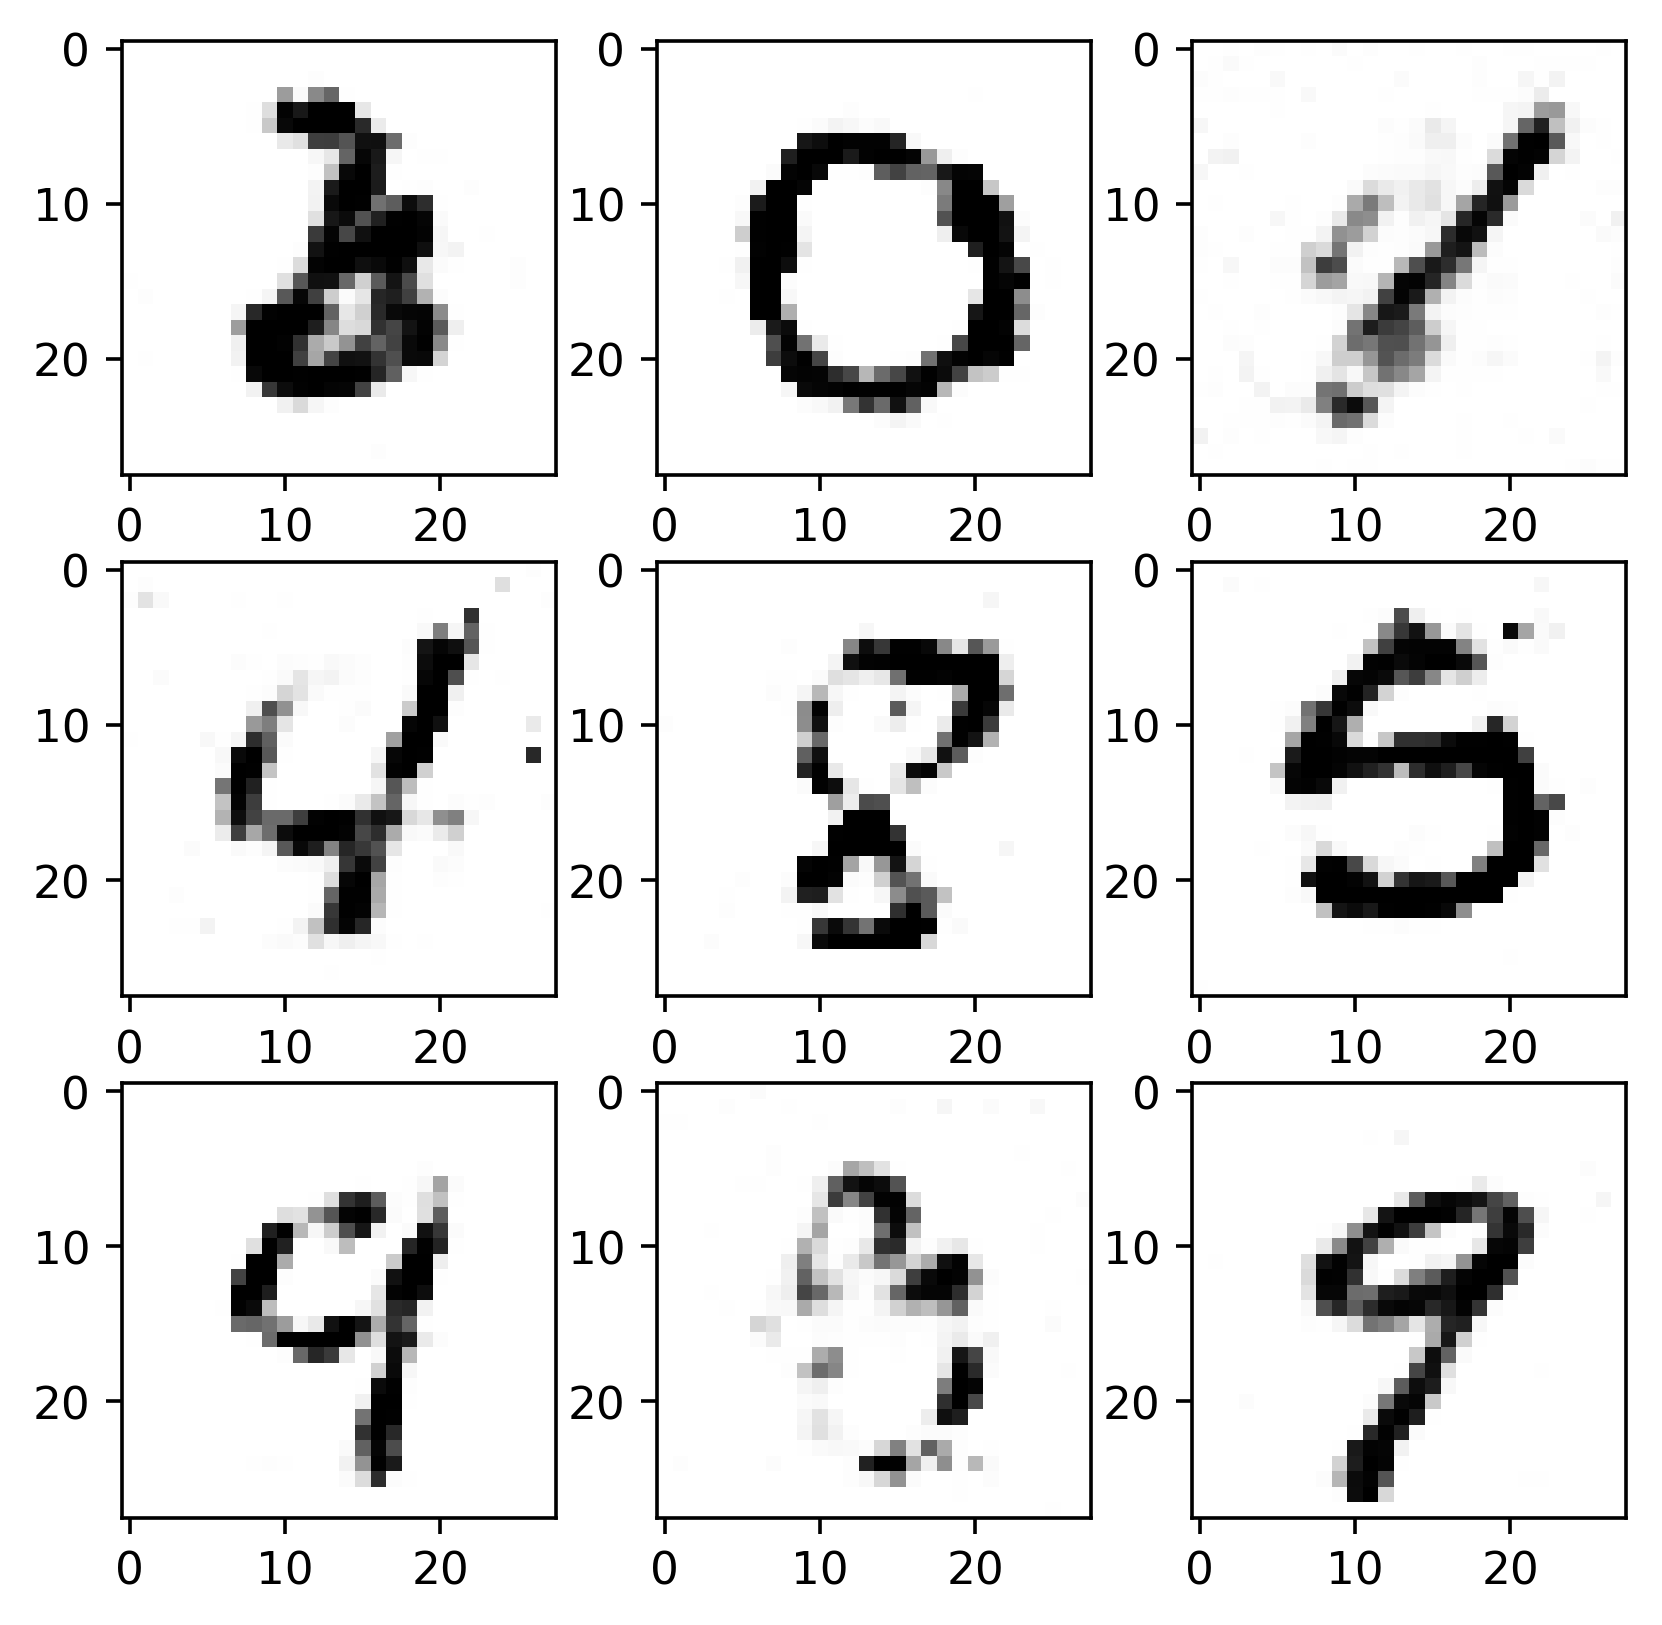

In [11]:
import matplotlib.pyplot as plt
import PIL
fig = plt.figure(figsize=(6, 6), dpi=326)
for i in range(3):
    for j in range(3):
        with torch.no_grad():
            ax = plt.subplot(3, 3, i * 3 + j + 1)
            noise = torch.randn(1, 100).cuda()
            fake_images = generator(noise)
            ax.imshow(fake_images.view(28, 28).cpu().numpy(), cmap="Greys")
plt.show()
plt.close("all")